# Fixed disease duration SIQR model with discretized time

Nils Bruin, April 4, 2020

The purpose of this worksheet is to compare some different non-pharmaceutical interventions in an SIR-type model:
 * *physical distancing*: where transmission rate of the disease is uniformly reduced (practically, by reducing the contact rate between all individuals in the population)
 * *quarantining measures*:
   - *isolation* reducing (to zero) the contact rate of some infectives -- because they become symptomatic
   - *testing* reducing (to zero) the contact rate of some infectives -- because they are detected by surveillance testing
   - *contact tracing* reducing (to zero) the contact rate of some infectives -- because they were infected by someone who was detected.

## Some comments on the dynamical effects of interventions

While all these interventions influence the dynamics by reducing $R_0$, they do so in different ways:
 * Physical distancing simply reduces $R_0$ by reducing the contact rate $C_\text{contact}$. The epidemic dynamics do not feed back into the effect otherwise.
 * Isolation reduces $R_0$ by reducing the infectivity, proportional to symptom onset. Epidemic dynamics do not feed back into the effect.
 * Testing increases quarantining rates proportional to the infected proportion. Since quarantining due to onset of symptoms is similarly driven, dynamically this can be covered by increasing the rate of symptom onset.
 * Contact tracing is a more targetted form of testing: it increases quarantining rates proportional to rate of infection, rather than by infected proportion.
The rate of infection is proportional to $SI$, so for constant $S$, contact tracing has a similar dynamical influence to testing and isolation. However it is less clear if $S$ can be considered constant over long time-spans and even if it is, it would be useful to see the relative strength of contact tracing compared to other measures.

## Model design

Contact tracing is not naturally modelled in a standard SIQR ODE model because the effect of it depends on the *history* of the infective rates. It is clear its effect will be amplification of the quarantining rates resulting from other measures, but it is not immediately clear how big this amplication factor is and how it will vary during the course of the epidemic.

**Assumption**: We assume fixed disease duration, rather than the exponentially distributed disease duration for the standar SIR ODE model. 

We implement this by discretizing time: we assume a disease duration of $1$, which we divide in $N$ slices: our time $t=T/N$, where $T\in \mathbb{Z}_{\geq 0}$. Correspondingly, we divide $I$ into $N$ compartments, to keep track of the *age* of the disease in our infected population.
$$I(T)=I_0(T)+\cdots+I_{N-1}(T)$$
We denote the susceptible and removed populations by $s(T)$ and $r(T)$ respectively.

Since we are keeping trace of the *age* of the disease in our infective population, it is natural to also keep track of the infectivity and rate of onset of symptoms as a funtion of that age:
For age $0\leq\alpha\leq1$ we characterize our disease with an infectivity distribution $\delta_\beta(\alpha)$ measuring the infectivity of an infective with disease age $\alpha$ and a distribution $\delta_q(\alpha)$ for the onset of symptoms: $1-\int_0^1 \delta_q(\alpha)d\alpha$ is the proportion of the infected population that does not develop symptoms as all.

**Assumption**: We assume that an infected person goes into quarantine as soon as symptoms develop.

We keep track of disease age in the quarantined population as well. This is not important for dynamics (these individuals are removed from the infective dynamics), but for diagnostic and policy reasons, it is still interesting to keep track of the quarantined population too: it serves as a proxy for the *observed* epidemic, while the $I(T)$ corresponds to the undiagnosed cases that actually drive the dynamics. We write
$$Q(T)=Q_0(T)+\cdots+Q_{N-1}(T).$$

We require the discretized rates
$$\beta(a)=\int_{\frac{a}{N}}^{\frac{a+1}{N}} \delta_\beta(\alpha) d\alpha\quad\text{   and   }\quad q(a)=\frac{\int_{\frac{a}{N}}^{\frac{a+1}{N}} \delta_q(\alpha) d\alpha}{1-\int_{0}^{\frac{a}{N}} \delta_q(\alpha) d\alpha}$$
(i.e., $q(a)$ is the proportion that develops symptoms at age $a/N<\alpha<(a+1)/n$ of the population that hasn't developed symptoms at age $\alpha<a/N$.)

We consider interventions. The *policy* in force at time $t$ consists of a vector $(C_\text{contact}(t),C_\text{test}(t),C_\text{trace}(t))$ measuring physical distancing measures, testing rate (in propertion of the population tested per unit time interval), and the proportion at which tracing is performed (0 being not at all, and 1 being perfect). 

We obtain the newly infected at time step $T$:
$$I_\text{new}(T)=\sum_{a=0}^{N-1} \beta'(a,T)I_a(T)\quad\text{ where }\quad\beta'(a,T)=\beta(a)C_\text{contact}(T)s(T)$$
and the newly quarantined of age $a$:
$$Q_\text{new}(a,T)=(q(a)+C_\text{test}/N)I_a(T)+\text{tracing contribution}$$
where we refer to the code below for the tedious procedure of computing, in terms of $\beta'(a,T)$ for previous time steps, the contribution to infection from these newly quarantined infectives, and the contribution of those, at eached step weighed by $C_\text{trace}(T)$.

We then have
$$\begin{aligned}
s(T+1)&=s(T)-I_\text{new}(T)\\
I_a(T+1)&=\begin{cases} I_\text{new}(T)& \text{ for }a=0\\
I_{a-1}(T)-Q_\text{new}(a,T)& \text{ for }a=1,\ldots,N-1
\end{cases}\\
Q_a(T+1)&=\begin{cases} 0& \text{ for }a=0\\
Q_{a-1}(T)+Q_\text{new}(a,T)& \text{ for }a=1,\ldots,N-1
\end{cases}\\
r(T+1)&=r(T)+I_{N-1}(T)+Q_{N-1}(T)
\end{aligned}$$

We implement this model below.

## Questions
* The distributions used for infectivity and symptom onset are only motivated by their shape. Are there better motivated distributions for them? Does it matter?
* What happens for $N\to\infty$? We should get some delay PDE. Then we can probably drop our compact support assumption too and get the exponentially distributed disease duration from the standard SIR model as well, giving insight in the factors with which contact tracing should be integrated there.
* A sensitivity analysis for $C_\text{contact},C_\text{test},C_\text{trace}$ would be interesting: it is clear that in different regimes these have quite different derivatives. Assigning cost functions to each measure, one could optimize for the best outcome (lowest $r_\infty$, lowest $Q_\text{max}$) within a budget and/or estimate the cost required to obtain an acceptable outcome.
* A lot of these questions make sense for a standard SIR model too. However, based on the preliminary test scenarios below, and a little playing around with the parameters, it does seem that $C_\text{trace}$ has a rather large effect, and because it's targetted testing, probably offers a lot of bang for buck. So quantifying the factors with which contact tracing should be incorporated in models seems very worthwhile.

In [1]:
import numpy as np
from numpy import exp, abs
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)


#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy):
        
        #discretize distributions
        beta=[quad(beta_dist,i/N,(i+1)/N)[0] for i in range(N)]
        quarantining_proportion=[quad(q_dist,i/N,(i+1)/N)[0] for i in range(N)]
        q=[]
        quarantined_proportion=[]
        running_total=0
        for i in range(N):
            q.append(quarantining_proportion[i]/(1-running_total))
            running_total+=quarantining_proportion[i]
            quarantined_proportion.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(quarantining_proportion)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.quarantining_proportion=quarantining_proportion
        self.quarantined_proportion=quarantined_proportion
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._betaprime=[]
        self.I0=I0
        self.N=N
        self.policy=policy
        self._policy=[]
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else 1-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,T/N)
        self._policy.append(policyT)
        C_contact,C_test,C_trace=policyT
        Ctst=C_test/N
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(c+Ctst)*i for c,i in zip(self.q,IT)]
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        for dT in range(self.N-1,-1,-1):
            for age in range(dT,self.N):
                Qnew[age-dT]+=self.betaprime(T-dT)[age-dT]*Qnew[age]*C_trace
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=int(np.floor(t*self.N))
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        xr=np.arange(0,1,0.01)
        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in xr]
        infection_coefficient=[quad(self.beta_dist,i/N,(i+1)/N)[0] for i in range(N)]
        R0=sum(infection_coefficient)
        ticks=np.arange(0+0.5/N,1,1/N)
        ax1.bar(ticks,[i*N for i in self.beta],alpha=0.5,width=1/N,label="infectivity integrated\n over intervals")
        ax1.plot(xr,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        ax1.text(0.2,0.5,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in xr]
        ax2.plot(xr,fvals,color="black",label="density")
        ax2.bar(ticks,[i*N for i in self.quarantining_proportion],alpha=0.5,width=1/N,label="integrated")
        ax2.bar(ticks,[i*N for i in self.q],alpha=0.2,color="red",width=1/N,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.text(0.1,0.2,"eventual symptomatic proportion = {:3.3}".format(sum(self.quarantining_proportion)))
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.bar(ticks,[1-p for p in self.quarantined_proportion],alpha=0.5,width=1/N)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.quarantined_proportion,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.bar(ticks,[N*c for c in q_adjusted_infection_coefficient],alpha=0.5,width=1/N)
        ax4.text(0.2,0.5,"R0q = {:3.3}".format(R0q))
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]
        ax3.plot(times,[1-a[0] for a in policy],label="physical distancing")
        ax3.plot(times,[a[1] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[2] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

In [2]:
beta_dist=compact_support_function(0,1,scale=5,shape=0.2,skew=1.2)
q_dist=compact_support_function(0,1,scale=1.05,skew=0.7,shape=0.6)

def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.001,policy=policy)

Test scenarios
==============

Below we illustrate a disease with $R_0=3.05$ and an symptom distribution that causes symptoms in about half the patients (eventually). We assume symptomatic patients are quarantined upon symptom onset, we get a quarantine-adjusted infectivity of $R_{0,q}=1.96$. If we run the simulation without interventions, we find that eventually about 80% gets infected, and maximum resource use (measured by maximum quarantined) is 9%

Note that our disease duration is 1, so when we simulate to $t=40$, then for a disease with a typical duration of $14$ days, this amounts to about 19 months.

r_infty = 0.808, Q_max= 0.092


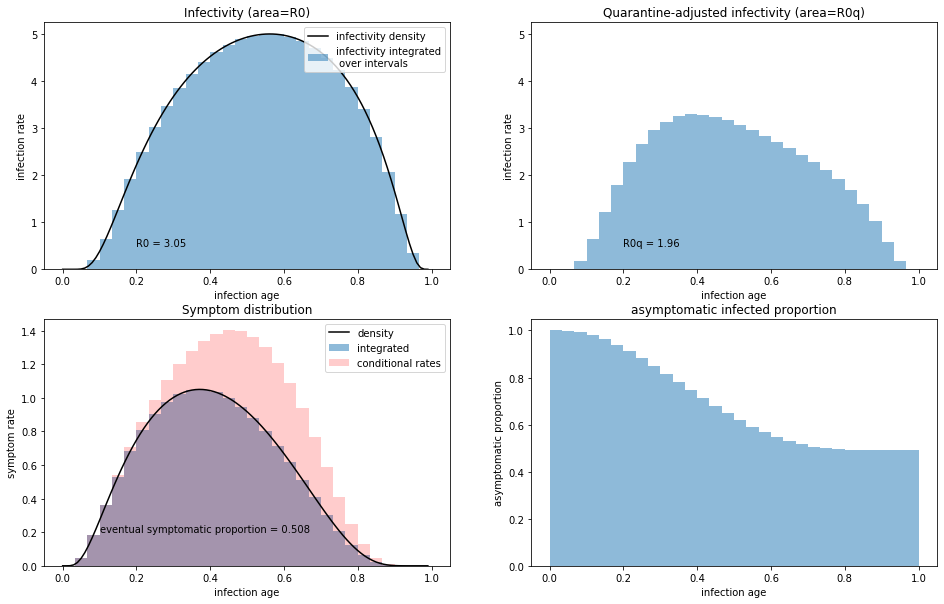

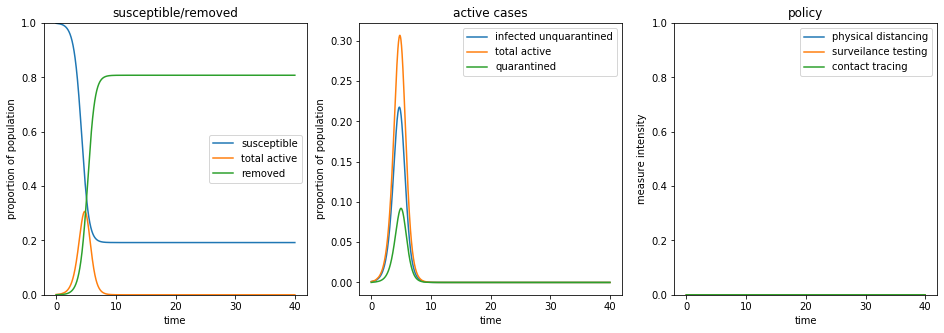

In [3]:
_=S.disease_plots()
_=S.time_plots(40)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

For comparison, we compute a completely unmitigated epidemic, where even symptomatic individuals are not quarantined. For dynamical purposes, this means we can simply set $\delta_q(\alpha)=0$. In the rest of the scenarios, we assume that symptomatic individuals are quarantined immediately.

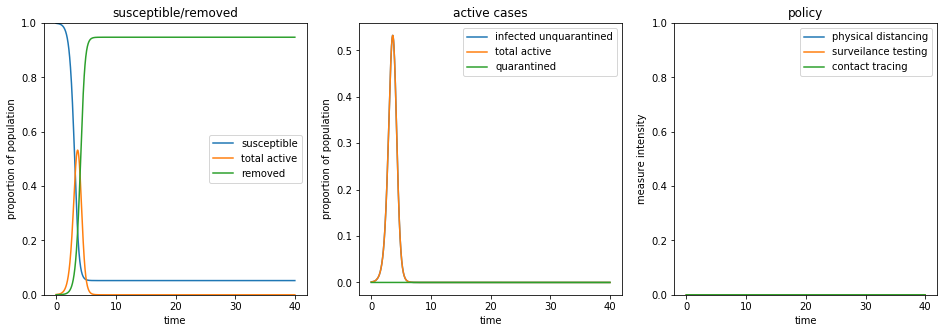

In [4]:
S=simulation(30,beta_dist,lambda alpha:0,0.001,policy=policy)
_=S.time_plots(40)

In the next scenario, we use pulsed physical distancing: whenever the quarantined population (these are the active cases we're aware of, and that use resources) exceeds $0.5\%$, we halve the contact rate. We see that resource use overshoots significantly (we get to 0.93%) and we land at a softer $r_\infty=0.58$, indicating that in the unmitigated epidemic we overshot herd immunity. Note that the herd immunity here is *with* perfect quarantining of symptomatic individuals.

r_infty = 0.582, Q_max= 0.00932


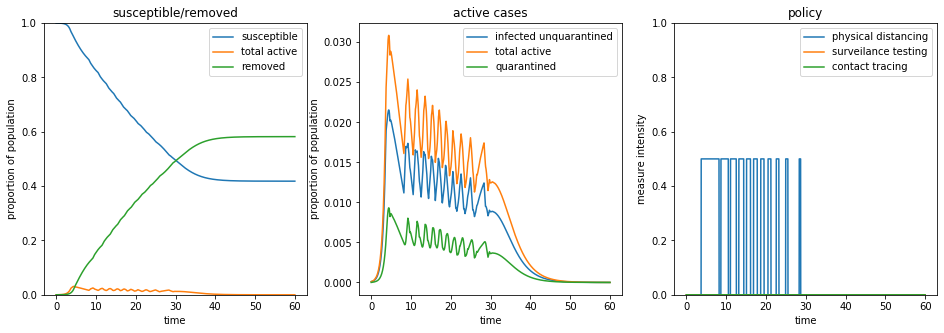

In [5]:
def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

We add testing: every time unit, we test 40% of the population. The effect is disappointing: yes, we lower to $r_\infty=47.7%$ and we soften our resource use, but testing 40% of the population every 2 weeks would be infeasible. Note that *quarantined* as a resource use measure is now contaminated: due to testing, there are now also asymptomatic persons in  quarantine.

r_infty = 0.476, Q_max= 0.00726


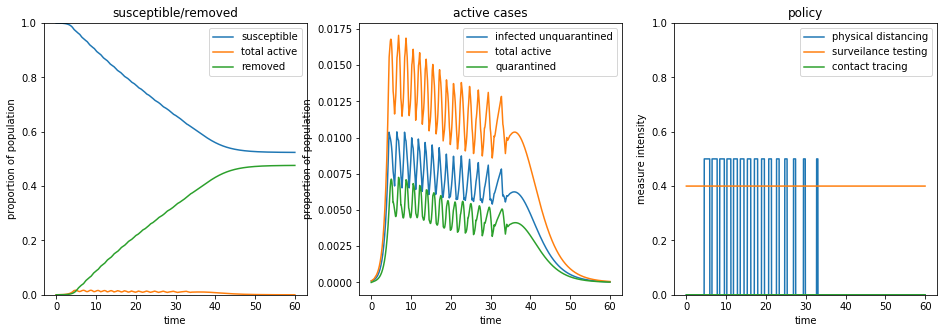

In [6]:
def policy(sim,t):
    C_contact=1
    C_test=0.4
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

We introduce contact tracing. As an illustration, we set $C_\text{trace}=0.9$ and reduce the testing rate to $C_\text{test}=0.33$. We see a dramatic drop in herd immunity level: $r_\infty=19\%$. We see that the pulsed physical distancing doesn't get activated.

r_infty = 0.19, Q_max= 0.00465


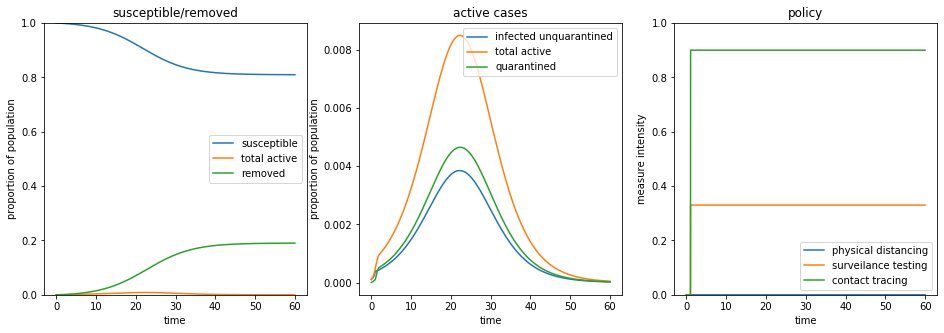

In [14]:
def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    if t>1:
        C_test=0.33
        C_trace=0.9

    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))